In [1]:
# Importing Libraries

import collections
import numpy as np
import random

import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
import tensorflow_federated as tff

import nest_asyncio
nest_asyncio.apply()

import warnings
warnings.filterwarnings("ignore")

In [2]:
# Checking installation of TF Federated

np.random.seed(0)

tf.compat.v1.enable_v2_behavior()
tff.federated_computation(lambda: 'Hello, World!')()

b'Hello, World!'

In [3]:
# Loading data

emnist_train, emnist_test = tff.simulation.datasets.emnist.load_data()
#cifar100_train, cifar100_test = tff.simulation.datasets.cifar100.load_data()

In [4]:
# Clients in train/test for EMNIST and CIFAR100

print("[EMNIST] Train Clients - ", len(emnist_train.client_ids))
print("[EMNIST] Test Clients - ", len(emnist_test.client_ids))

#print("[CIFAR100] Train Clients - ", len(cifar100_train.client_ids))
#print("[CIFAR100] Test Clients - ", len(cifar100_test.client_ids))

[EMNIST] Train Clients -  3383
[EMNIST] Test Clients -  3383


In [5]:
# Data Structure
print("EMNIST - ", emnist_train.element_type_structure)
#print("CIFAR100 - ", cifar100_train.element_type_structure)

EMNIST -  OrderedDict([('label', TensorSpec(shape=(), dtype=tf.int32, name=None)), ('pixels', TensorSpec(shape=(28, 28), dtype=tf.float32, name=None))])


Total Images for Client 3 - 100


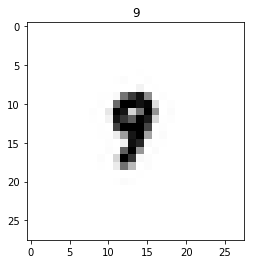

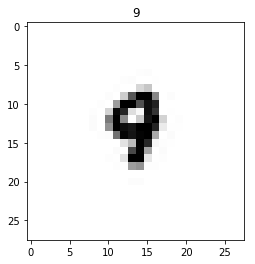

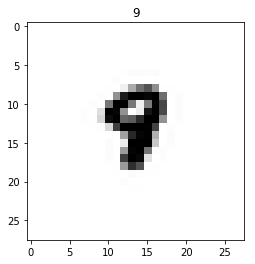

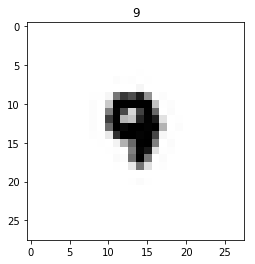

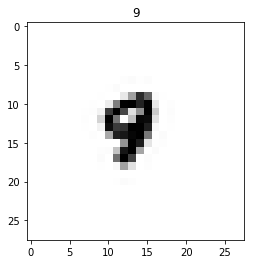

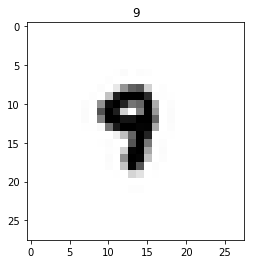

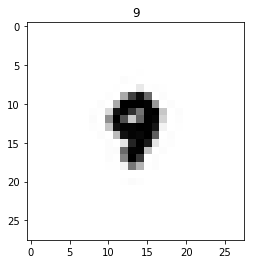

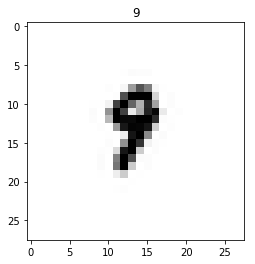

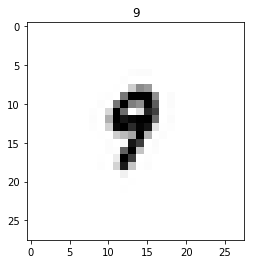

In [6]:
# Sample Image

client_no = 3
label_plot = 9

def count_iterable(i):
    return sum(1 for e in i)

example_dataset = emnist_train.create_tf_dataset_for_client(emnist_train.client_ids[client_no])

print("Total Images for Client %d - %d"%(client_no, count_iterable(example_dataset)))

for i in iter(example_dataset):
    example_element = i
    if example_element['label'].numpy() == label_plot:
        plt.imshow(example_element['pixels'].numpy(), cmap='gray', aspect='equal')
        plt.title(example_element['label'].numpy())
        plt.grid(False)
        _ = plt.show()

In [7]:
NUM_EPOCHS = 20
BATCH_SIZE = 20
SHUFFLE_BUFFER = 100
PREFETCH_BUFFER = 10

def preprocess(dataset):

    def batch_format_fn(element):
        """
        Flatten a batch `pixels` and return the features as an `OrderedDict`.
        """
        return collections.OrderedDict(
            x = tf.reshape(element['pixels'], [-1, 28*28]),
            y = tf.reshape(element['label'], [-1, 1]))

    return dataset.repeat(NUM_EPOCHS).shuffle(SHUFFLE_BUFFER).batch(BATCH_SIZE).map(batch_format_fn).prefetch(PREFETCH_BUFFER)

In [8]:
# Preprocessing for Client 0
preprocessed_example_dataset = preprocess(example_dataset)

sample_batch = tf.nest.map_structure(lambda x: x.numpy(), next(iter(preprocessed_example_dataset)))

sample_batch

OrderedDict([('x',
              array([[1., 1., 1., ..., 1., 1., 1.],
                     [1., 1., 1., ..., 1., 1., 1.],
                     [1., 1., 1., ..., 1., 1., 1.],
                     ...,
                     [1., 1., 1., ..., 1., 1., 1.],
                     [1., 1., 1., ..., 1., 1., 1.],
                     [1., 1., 1., ..., 1., 1., 1.]], dtype=float32)),
             ('y',
              array([[1],
                     [3],
                     [5],
                     [5],
                     [7],
                     [7],
                     [5],
                     [3],
                     [6],
                     [4],
                     [7],
                     [7],
                     [9],
                     [6],
                     [3],
                     [6],
                     [8],
                     [6],
                     [7],
                     [9]], dtype=int32))])

In [9]:
# Creating federated data
def make_federated_data(client_data, client_ids):
    
    return [preprocess(client_data.create_tf_dataset_for_client(x)) for x in client_ids]

# Picking clients
NUM_CLIENTS = 10
sample_clients = emnist_train.client_ids[0:NUM_CLIENTS]

federated_train_data = make_federated_data(emnist_train, sample_clients)

print('Number of client datasets: {l}'.format(l=len(federated_train_data)))
print('First dataset: {d}'.format(d=federated_train_data[0]))

Number of client datasets: 10
First dataset: <PrefetchDataset shapes: OrderedDict([(x, (None, 784)), (y, (None, 1))]), types: OrderedDict([(x, tf.float32), (y, tf.int32)])>


In [10]:
def create_keras_model():
    
    #return tf.keras.applications.ResNet50()
    
    return tf.keras.models.Sequential(
        [
            tf.keras.layers.Input(shape=(28*28,)),
            tf.keras.layers.Dense(10, kernel_initializer='zeros'),
            tf.keras.layers.Softmax()
        ]
    )

In [11]:
def model_fn():
    """
    We _must_ create a new model here, and _not_ capture it from an external
    scope. TFF will call this within different graph contexts.
    """
    
    return tff.learning.from_keras_model(create_keras_model(),
                                         dummy_batch=sample_batch,
                                         loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                                         metrics=[
                                             tf.keras.metrics.SparseCategoricalAccuracy()
                                         ])

In [17]:
iterative_process = tff.learning.build_federated_averaging_process(
    model_fn,
    client_optimizer_fn=lambda: tf.keras.optimizers.Adam(learning_rate=1e-3),
    server_optimizer_fn=lambda: tf.keras.optimizers.Adam(learning_rate=1e-2)
)

evaluation = tff.learning.build_federated_evaluation(model_fn)

In [18]:
str(iterative_process.initialize.type_signature), str(evaluation.type_signature)

('( -> <model=<trainable=<float32[784,10],float32[10]>,non_trainable=<>>,optimizer_state=<int64,float32[784,10],float32[10],float32[784,10],float32[10]>,delta_aggregate_state=<>,model_broadcast_state=<>>@SERVER)',
 '(<<trainable=<float32[784,10],float32[10]>,non_trainable=<>>@SERVER,{<x=float32[?,784],y=int32[?,1]>*}@CLIENTS> -> <sparse_categorical_accuracy=float32@SERVER,loss=float32@SERVER,keras_training_time_client_sum_sec=float32@SERVER>)')

In [19]:
results = {}
results['no_shuffle'] = {
    'train_acc': [],
    'test_acc': [],
    'train_loss': [],
    'test_loss': []
}
results['shuffle'] = {
    'train_acc': [],
    'test_acc': [],
    'train_loss': [],
    'test_loss': []
}

In [20]:
NUM_ROUNDS = 100

for shuffle in [1]:

    # Initializing the process
    state = iterative_process.initialize()

    for round_num in range(1, NUM_ROUNDS):

        NUM_CLIENTS = 10
        common_clients = list(set(list(emnist_train.client_ids)) & set(list(emnist_test.client_ids)))
        if shuffle == 1:
            random.shuffle(common_clients)
        sample_clients = common_clients[:NUM_CLIENTS]

        federated_train_data = make_federated_data(emnist_train, sample_clients)
        federated_test_data = make_federated_data(emnist_test, sample_clients)
        
        state, train_metrics = iterative_process.next(state, federated_train_data)
        test_metrics = evaluation(state.model, federated_test_data)
        
        train_acc = train_metrics.sparse_categorical_accuracy*100.0
        train_loss = train_metrics.loss
        test_acc = test_metrics.sparse_categorical_accuracy*100.0
        test_loss = test_metrics.loss

        print('Round {:2d}, Train Accuracy {:2f}, Test Accuracy {:2f}, Train Loss {:2f}, Test Loss {:2f}'.format(
            round_num, train_acc, test_acc, train_loss, test_loss))
        
        if shuffle == 1:
            results['shuffle']['train_acc'].append(train_acc)
            results['shuffle']['test_acc'].append(test_acc)
            results['shuffle']['train_loss'].append(train_loss)
            results['shuffle']['test_loss'].append(test_loss)
        else:
            results['no_shuffle']['train_acc'].append(train_acc)
            results['no_shuffle']['test_acc'].append(test_acc)
            results['no_shuffle']['train_loss'].append(train_loss)
            results['no_shuffle']['test_loss'].append(test_loss)

Round  1, Train Accuracy 37.312374, Test Accuracy 29.661018, Train Loss 2.010817, Test Loss 5.258802
Round  2, Train Accuracy 41.108423, Test Accuracy 5.645161, Train Loss 2.117318, Test Loss 4.830682
Round  3, Train Accuracy 42.474177, Test Accuracy 22.400001, Train Loss 2.006988, Test Loss 2.880118
Round  4, Train Accuracy 53.509802, Test Accuracy 14.049587, Train Loss 1.770720, Test Loss 3.935277
Round  5, Train Accuracy 56.262732, Test Accuracy 10.833333, Train Loss 1.739857, Test Loss 3.149243
Round  6, Train Accuracy 59.315628, Test Accuracy 38.461539, Train Loss 1.658805, Test Loss 2.095560
Round  7, Train Accuracy 58.057451, Test Accuracy 35.772356, Train Loss 1.655287, Test Loss 2.333279
Round  8, Train Accuracy 66.875625, Test Accuracy 32.773110, Train Loss 1.452230, Test Loss 2.548678
Round  9, Train Accuracy 63.978243, Test Accuracy 17.460318, Train Loss 1.515323, Test Loss 2.606734
Round 10, Train Accuracy 71.275204, Test Accuracy 9.322034, Train Loss 1.366186, Test Loss 2

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/Users/Akhil/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-20-83564ef82f42>", line 19, in <module>
    state, train_metrics = iterative_process.next(state, federated_train_data)
  File "/Users/Akhil/anaconda3/envs/fl/lib/python3.6/site-packages/tensorflow_federated/python/core/impl/utils/function_utils.py", line 592, in __call__
    return context.invoke(self, arg)
  File "/Users/Akhil/anaconda3/envs/fl/lib/python3.6/site-packages/retrying.py", line 49, in wrapped_f
    return Retrying(*dargs, **dkw).call(f, *args, **kw)
  File "/Users/Akhil/anaconda3/envs/fl/lib/python3.6/site-packages/retrying.py", line 206, in call
    return attempt.get(self._wrap_exception)
  File "/Users/Akhil/anaconda3/envs/fl/lib/python3.6/site-packages/retrying.py", line 247, in get
    six.reraise(self.value[0], self.value[1], self.value[2])
  F

KeyboardInterrupt: 

In [19]:
import matplotlib.pyplot as plt
%matplotlib inline

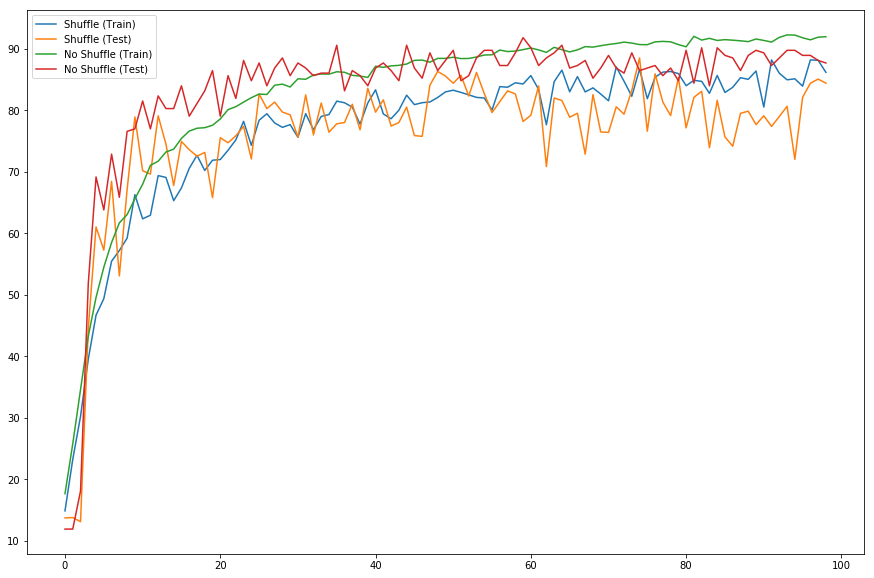

In [20]:
plt.figure(figsize=(15, 10))
plt.plot(results['shuffle']['train_acc'], label='Shuffle (Train)')
plt.plot(results['shuffle']['test_acc'], label='Shuffle (Test)')
plt.plot(results['no_shuffle']['train_acc'], label='No Shuffle (Train)')
plt.plot(results['no_shuffle']['test_acc'], label='No Shuffle (Test)')
plt.legend()
plt.show()